In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import os.path

In [163]:
# from math import pi

# from bokeh.io import output_file, show
# from bokeh.layouts import column
# from bokeh.models import ColumnDataSource, CustomJS, Slider
# from bokeh.plotting import figure

# output_file("pie.html")

# source = ColumnDataSource(data=dict(
#     start=[0, 0.2], end=[0.2, 2*pi], color=['firebrick', 'navy']
# ))

# plot = figure()
# plot.wedge(x=0, y=0, start_angle='start', end_angle='end', radius=1,
#         color='color', alpha=0.6, source=source)

# slider = Slider(start=.1, end=1., value=.2, step=.1, title="delta-V")

# def update(source=source, slider=slider, window=None):
#     data = source.data
#     data['end'][0] = slider.value
#     source.trigger('change')

# slider.js_on_change('value', CustomJS.from_py_func(update))

# show(column(slider, plot))

In [8]:
def split_profession(str):
    return str.split(',')

In [12]:
if os.path.exists('./pickles/filtered_actors.pkl'):
    print("Reading from pickle...")
    actors = pd.read_pickle("./pickles/filtered_actors.pkl")
else:
    people_df = pd.read_csv(
        './data/name.basics.tsv.gz',
        sep='\t',
        converters={'primaryProfession': split_profession}
    )
    people_prof_exploded = people_df.explode('primaryProfession')
    actors = people_prof_exploded[
        (people_prof_exploded.primaryProfession == 'actress') | (people_prof_exploded.primaryProfession == 'actor')]
    actors.to_pickle("./pickles/filtered_actors.pkl")
actors.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,actor,"tt0050419,tt0053137,tt0043044,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,actress,"tt0117057,tt0037382,tt0071877,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,actress,"tt0049189,tt0059956,tt0054452,tt0057345"
3,nm0000004,John Belushi,1949,1982,actor,"tt0078723,tt0080455,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,actor,"tt0050986,tt0083922,tt0069467,tt0050976"


In [20]:
movie_cast = pd.read_pickle("./pickles/complete_cast.pkl")
movies = pd.read_pickle("./pickles/filtered_movies.pkl")
movie_cast

,tconst,cast,count
0,tt0788137,"[nm2213445, nm2216523, nm2212320, nm2219080, n...",6
1,tt0788133,"[nm2100867, nm1952207, nm2218383, nm5041940, n...",6
2,tt0788141,"[nm0149867, nm0708218, nm0899804]",3
3,tt0788134,"[nm1833642, nm1044987, nm2756644, nm1833094, n...",5
4,tt0790463,"[nm2214417, nm2213293]",2
...,...,...,...
538012,tt7172590,[nm7502202],1
538013,tt11088928,"[nm0608846, nm2792327, nm9117281]",3
538014,tt2577910,[nm5174887],1
538015,tt11369300,[nm11170433],1


In [19]:
movie_cast_expl = movie_cast.explode('cast')
movie_cast_expl

,tconst,cast,count
0,tt0788137,nm2213445,6
0,tt0788137,nm2216523,6
0,tt0788137,nm2212320,6
0,tt0788137,nm2219080,6
0,tt0788137,nm2214137,6
...,...,...,...
538015,tt11369300,nm11170433,1
538016,tt10294344,nm0015321,4
538016,tt10294344,nm0015440,4
538016,tt10294344,nm0461981,4


In [27]:
cast_info = movie_cast_expl.merge(actors, left_on='cast', right_on='nconst', how='inner')

In [33]:
cast_info

,tconst,cast,count,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,tt0788133,nm2100867,6,nm2100867,Janine Chun-Ning Chang,1982,\N,actress,"tt8791742,tt7070302,tt1239313,tt0486480"
1,tt0788250,nm2100867,5,nm2100867,Janine Chun-Ning Chang,1982,\N,actress,"tt8791742,tt7070302,tt1239313,tt0486480"
2,tt1051267,nm2100867,12,nm2100867,Janine Chun-Ning Chang,1982,\N,actress,"tt8791742,tt7070302,tt1239313,tt0486480"
3,tt1909830,nm2100867,8,nm2100867,Janine Chun-Ning Chang,1982,\N,actress,"tt8791742,tt7070302,tt1239313,tt0486480"
4,tt3421246,nm2100867,38,nm2100867,Janine Chun-Ning Chang,1982,\N,actress,"tt8791742,tt7070302,tt1239313,tt0486480"
...,...,...,...,...,...,...,...,...,...
6277468,tt8710596,nm10959710,43,nm10959710,Michael Stanton,\N,\N,actor,"tt4572514,tt1289401,tt4465572,tt8710596"
6277469,tt8710596,nm9505963,43,nm9505963,Ed LaVache,\N,\N,actor,\N
6277470,tt8710596,nm10364750,43,nm10364750,John Miranda,\N,\N,actor,tt8784956
6277471,tt8710596,nm10483754,43,nm10483754,Brooke Arcadio Navarro,\N,\N,actress,tt8834580


In [94]:
# tconst_prof = cast_info[0:5000].groupby(['tconst','primaryProfession']).size()
# tconst_prof.get('tt0000941')

primaryProfession
actor    1
dtype: int64

In [112]:
# Groupby will not show when one of the value is 0. so do a pivot
tconst_genders = cast_info.pivot_table(index='tconst', 
                     columns='primaryProfession', 
                     values='count',
                     fill_value=0, 
                     aggfunc='count')
# tconst_genders.loc['tt0000941']
tconst_genders

primaryProfession,actor,actress
tconst,,
tt0000009,2,1
tt0000147,1,0
tt0000335,5,1
tt0000502,2,0
tt0000574,12,3
...,...,...
tt9916538,11,4
tt9916622,2,0
tt9916680,6,2


In [130]:
tconst_genders['total'] = tconst_genders['actor'] + tconst_genders['actress']
tconst_genders['male'] = tconst_genders['actor'] / tconst_genders['total']
tconst_genders['female'] = tconst_genders['actress'] / tconst_genders['total']

In [131]:
with pd.option_context('display.max_rows', 5000, 'display.max_columns', 20):
    display(tconst_genders)

primaryProfession,actor,actress,male,female,total
tconst,,,,,
tt0000009,2,1,0.666667,0.333333,3
tt0000147,1,0,1.000000,0.000000,1
tt0000335,5,1,0.833333,0.166667,6
tt0000502,2,0,1.000000,0.000000,2
tt0000574,12,3,0.800000,0.200000,15
...,...,...,...,...,...
tt9916538,11,4,0.733333,0.266667,15
tt9916622,2,0,1.000000,0.000000,2
tt9916680,6,2,0.750000,0.250000,8


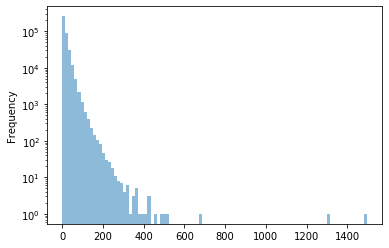

In [140]:
fig, ax = plt.subplots()
tconst_genders.total.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')


We can see that many of the movies do not have any cast information. It is safe to assume that the ones that have a very low number of cast members are not credible as movies. So here onwards, we will use the movies that has a cast count of more than 10 for the gender based analysis.

Text(0.5, 0, 'Gender percentage')

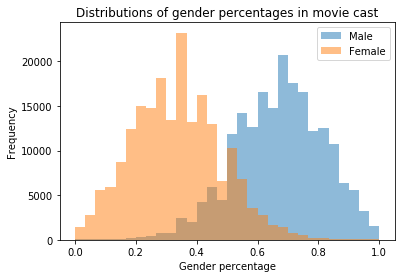

In [161]:
# Consider movies that have a total cast count of atleast 10 since the rest do not seem like credible
tconst_genders_cred = tconst_genders[tconst_genders.total > 10]
ax = tconst_genders_cred[['male', 'female']].plot.hist(bins=30, alpha=0.5)
ax.set_title('Distributions of gender percentages in movie cast')
ax.legend(['Male', 'Female'])
ax.set_xlabel('Gender percentage')

In general females are underrepresented in the cast of movies. The following pie chart demonstrates the mean representation percentage of both the genders.

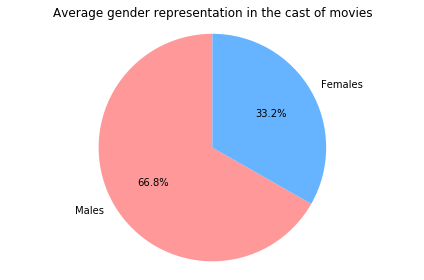

In [158]:
mean_males = tconst_genders_cred.male.mean()
labels = ['Males', 'Females']
sizes = [mean_males, 1 - mean_males]
colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')  
ax1.set_title('Average gender representation in the cast of movies')
plt.tight_layout()
plt.show()

Next we check if this situation is different in the successful movies